2023 Bart Smeets

# Z-Scan Fit

## Imports

In [1]:
# Python standard library
from datetime import datetime
import os, sys
import tkinter as tk
from tkinter import filedialog

# Required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Included in repository
from z_scan import errorbar
from z_scan import export_functions
from z_scan import fitting_model
from z_scan.fitting_model.absorption import intensity

## Load data

In [2]:
# Create window to select data-file
INITIAL_PATH = os.environ.get('THESIS_DATA')
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
FILE_PATH = filedialog.askopenfilename(initialdir=INITIAL_PATH, title='Select data')
root.destroy()


# Change working directory
## Directory is the folder where the selected file is located
index = FILE_PATH.rfind('/')
DIRECTORY = FILE_PATH[:index]
FILE_NAME = FILE_PATH[index+1:-4]
os.chdir(DIRECTORY)


# Load data
## And seperate into physical arrays
MEASUREMENT = np.loadtxt(FILE_NAME + '.txt')
Z_DATA = MEASUREMENT[:, 0]
I_DATA = MEASUREMENT[:, 1]
SIGMA_I = MEASUREMENT[:,2]


# Load parameter data (if existing)
if os.path.exists('INPUT_PARAMETERS.csv'):
    PARAMETER_DATA = pd.read_csv('INPUT_PARAMETERS.csv', sep=r';', header=0, skiprows=[1], skipinitialspace = True)
else:
    sys.exit('"INPUT_PARAMETERS.csv" not in directory')


# Convert parameters to proper units
PULSE_WIDTH = 6e-9 # 5-8 ns
ALPHA0 = float(PARAMETER_DATA['alpha']) / 10    # Convert cm-1 to mm-1
Z_R = float(PARAMETER_DATA['zR']) * 1e-3    # Convert um to mm
W0 = float(PARAMETER_DATA['W0']) * 1e-3   # Convert um to mm
E_PULSE = float(PARAMETER_DATA['Pulse Energy']) * 1e-6    # Convert uJ to J
P_LASER = E_PULSE / 6e-9
I0 = 2*P_LASER / (np.pi * W0**2)
L = float(PARAMETER_DATA['L']) * 10   # Convert cm to mm

print(r'I0 = %.2e W/mm-2' %(I0,))

I0 = 5.19e+05 W/mm-2


## Plot raw data

<function matplotlib.pyplot.show(close=None, block=None)>

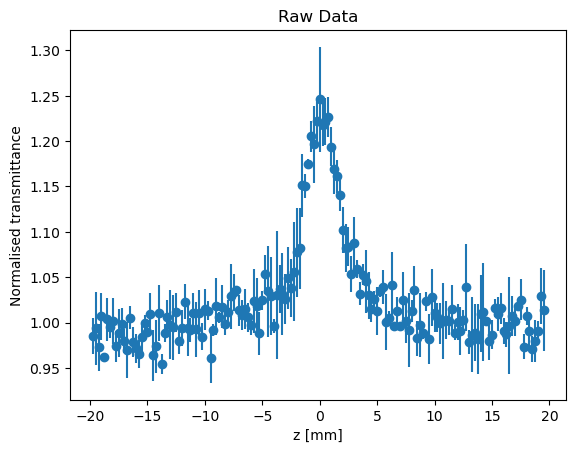

In [3]:
fig1 = plt.figure()

plt.errorbar(Z_DATA, I_DATA, SIGMA_I, fmt='o')

plt.title('Raw Data')
plt.xlabel('z [mm]')
plt.ylabel('Normalised transmittance')

plt.show

## Fit

In [4]:
# User Input
## Fit type
### 0: 1PA | 1: 2PA no Is2 | 2: 2PA | 3: 2PA no Is1 | 4: 2PA no sat
FIT_TYPE = 4
## Initial guess
### Only the parameters corresponding to FIT_TYPE are considered. The others are ignored.
Z0_0 = 0
I_S1_0 = 1e5
I_S2_0 = 1e-5
BETA_0 = 1e-5
## Model Parameters
N_RUNS = 3                     # Number of independent model calculations
MAX_PERTURBATION = 10              # Max perturbation size 
BOUNDS = [(-5, 5), (1e-99, None), (1e-99, None), (0, None)]  # Bounds of fitting-parameters: z0, Is1
MAX_ITER = 500                    # Max number of iterations (stop-condition) (0 = classical algorithm)
MAX_AGE = 50                      # Max age of best Chi2 (stop-condition)
T = 0.8                            # Temperature (related to probability of a non optimal chi2 being taken as step)
MAX_JUMP = 5                       # Number of jumps permitted
MAX_REJECT = 5                     # Local minimum treshold


# Pack Parameters
P0 = [Z0_0, I_S1_0, I_S2_0, BETA_0]
MODEL_PARAMETERS = [MAX_PERTURBATION, MAX_AGE, MAX_ITER, BOUNDS, T, MAX_JUMP, MAX_REJECT]
EXPERIMENT_PARAM = [L, ALPHA0, I0, Z_R]

# Run model
RUNS, P_BEST, CHI2_BEST = fitting_model.run(MEASUREMENT, FIT_TYPE, N_RUNS, P0, MODEL_PARAMETERS, EXPERIMENT_PARAM)
RESULT_STRING = export_functions.text.best(FIT_TYPE, CHI2_BEST, P_BEST)
print(RESULT_STRING)

X2 = 1.23e+03
z0 = -5.00 mm
beta = 0.00e+00 mm/W


## Plot results

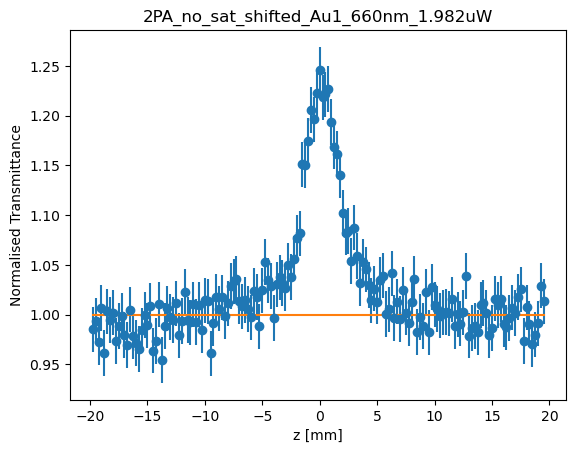

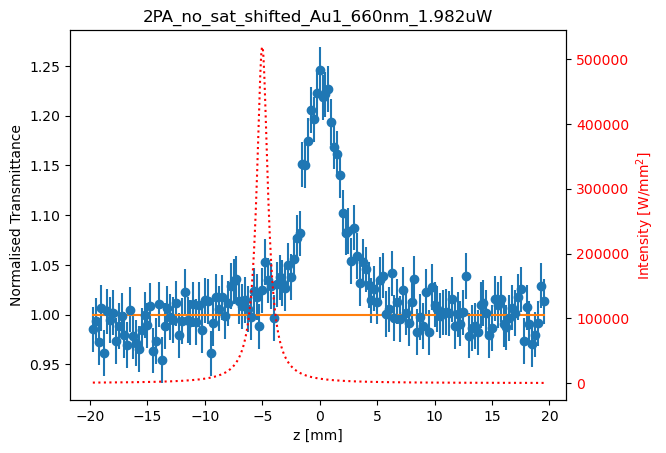

d:\Users\Bart\OneDrive - KU Leuven\Vakken\Master\Master 2\Thesis\Z-Scan\Code\zscan-fit\z_scan\export_functions\plot.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  ax.axvline(experiment_param[1]/p_best[-1], ls=':', color='red', label=r'$\alpha / \beta$')


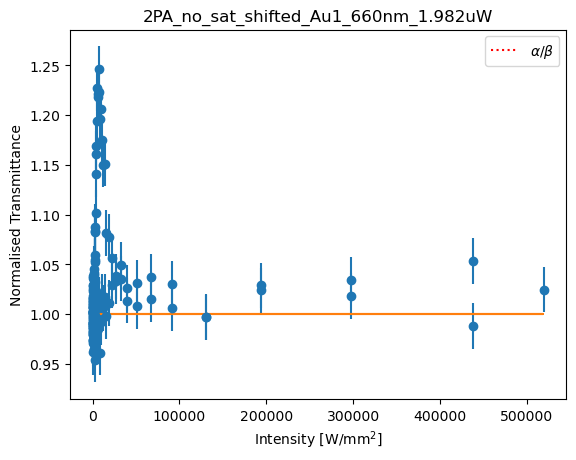

TypeError: only size-1 arrays can be converted to Python scalars

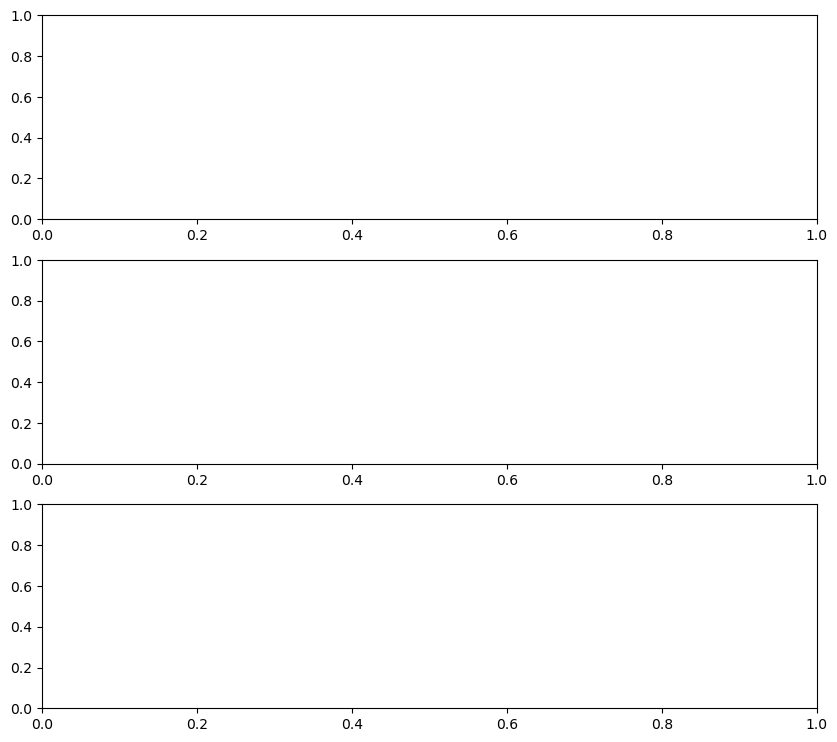

In [5]:
Z_PLOT = np.linspace(Z_DATA[0], Z_DATA[-1], 1000)
SIGMA_PLOT = np.ones(np.size(SIGMA_I)) * np.average(SIGMA_I)

# Prepare Title
FIT_TYPE_STRING = ['1PA', '2PA_no_Is2', '2PA', '2PA_no_Is1', '2PA_no_sat'][FIT_TYPE]
TITLE = FIT_TYPE_STRING + '_' + FILE_NAME


# T(z)
fig2, ax2 = plt.subplots()
export_functions.plot.Tz(ax2, Z_DATA, I_DATA, Z_PLOT, SIGMA_PLOT, FIT_TYPE, P_BEST, EXPERIMENT_PARAM)
## Labels
ax2.set_xlabel('z [mm]')
ax2.set_ylabel('Normalised Transmittance')
ax2.set_title(TITLE)
plt.show()


# T(z) with I(z)
fig2_2, ax2_2 = plt.subplots()
ax2_3 = ax2_2.twinx()  
export_functions.plot.Tz(ax2_2, Z_DATA, I_DATA, Z_PLOT, SIGMA_PLOT, FIT_TYPE, P_BEST, EXPERIMENT_PARAM)
ax2_3.plot(Z_PLOT, intensity(Z_PLOT, P_BEST[0], I0, Z_R), linestyle=':', color='red')
ax2_2.set_xlabel('z [mm]')
ax2_2.set_ylabel('Normalised Transmittance')
ax2_2.set_title(TITLE)
ax2_3.set_ylabel(r'Intensity [W/mm$^{2}$]', color='red')
ax2_3.tick_params(axis='y', labelcolor='red')
plt.show()


# T(I)
fig2_1, ax2_1 = plt.subplots()
export_functions.plot.TI(ax2_1, Z_DATA, I_DATA, Z_PLOT, SIGMA_PLOT, FIT_TYPE, P_BEST, EXPERIMENT_PARAM)
##Labels
ax2_1.set_xlabel(r'Intensity [W/mm$^{2}$]')
ax2_1.set_ylabel('Normalised Transmittance')
ax2_1.set_title(TITLE)
ax2_1.legend()
plt.show()


# Plot all runs
fig3, ax3 = plt.subplots(N_RUNS, 1, figsize=(10,3*N_RUNS))
for i in range(N_RUNS):
    textstr = export_functions.text.individual(FIT_TYPE, RUNS, i)
    export_functions.plot.Tz(ax3[i], Z_DATA, I_DATA, Z_PLOT, SIGMA_PLOT, FIT_TYPE, RUNS[i,:-1], EXPERIMENT_PARAM)
    ax3[i].text(5,1.1, textstr)
plt.show()

## Calculate errorbars

In [6]:
SIGMA_P, CHI2_SPAN = errorbar.compute(MEASUREMENT, FIT_TYPE, P_BEST, CHI2_BEST, EXPERIMENT_PARAM)
OUTPUT_STRING = export_functions.text.output(FIT_TYPE, CHI2_BEST, P_BEST, SIGMA_P, CHI2_SPAN)
print(OUTPUT_STRING)

Fitting Parameters
X2 = 1.23e+03
z0 = (-5.00 +- 1.97) mm; X2 span: 1228.55
beta = (0.00e+00 +- 0.0e+00)  mm/W; X2 span: 1228.55


## Export Results

In [7]:
# Create export directory
timeCode = datetime.now()
EXPORT_FOLDER = "/FIT_RESULTS_" + TITLE + '_' +timeCode.strftime("%Y%m%d-%H%M")
EXPORT_DIRECTORY = DIRECTORY + EXPORT_FOLDER
os.mkdir(EXPORT_DIRECTORY)
os.chdir(EXPORT_DIRECTORY)

# Save figures
fig1.savefig('OUTPUT_' + TITLE + '_RAW_DATA.png', bbox_inches='tight')
fig2.savefig('OUTPUT_' + TITLE + '_Tz.png', bbox_inches='tight')
fig2_1.savefig('OUTPUT_' + TITLE + '_TI.png', bbox_inches='tight')
fig2_2.savefig('OUTPUT_' + TITLE + '_Tz_TI.png', bbox_inches='tight')
fig3.savefig('OUTPUT_' + TITLE + '_ALL_RUNS.png', bbox_inches='tight')

# Export results
## Prepare Parameter string for export
PARAMETER_STRING = textstr = '\n'.join((
    r'Model Parameters',
    r'alpha0 = %.2f cm-1' % (ALPHA0*10, ),
    r'L = %.1f cm' % (L/10, ),
    r'w0 = %.2f um' % (W0*1e3, ),
    r'zR = %.2f um' % (Z_R*1e3, ),
    r'E_pulse = %.2f uJ' % (E_PULSE*1e6, ),
    r'I0 = %.2e  W/mm2' % (I0, )))

output_file = open('RESULTS_' + TITLE + '.txt', 'wt')
output_file.write(PARAMETER_STRING)
output_file.write('\n\n')
output_file.write(OUTPUT_STRING)
output_file.close()

# Open output folder
os.startfile(EXPORT_DIRECTORY)